In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import probplot
from kika.endf.read_endf import read_endf

# Read file
parquet_path = '/mnt/c/Users/MONLEON-DE-LA-JAN/Documents/samples/endf_pert/endf_perturbation_factors_20250811_140105.parquet'
df = pd.read_parquet(parquet_path)

In [21]:
for i in df.columns:
    print(i)    

Sample_ID
Fe56_MT2_L1_E0-E1
Fe56_MT2_L1_E1-E2
Fe56_MT2_L1_E2-E3
Fe56_MT2_L1_E3-E4
Fe56_MT2_L2_E0-E1
Fe56_MT2_L2_E1-E2
Fe56_MT2_L2_E2-E3
Fe56_MT2_L2_E3-E4
Fe56_MT2_L3_E0-E1
Fe56_MT2_L3_E1-E2
Fe56_MT2_L3_E2-E3
Fe56_MT2_L3_E3-E4
Fe56_MT2_L4_E0-E1
Fe56_MT2_L4_E1-E2
Fe56_MT2_L4_E2-E3
Fe56_MT2_L4_E3-E4
Fe56_MT2_L5_E0-E1
Fe56_MT2_L5_E1-E2
Fe56_MT2_L5_E2-E3
Fe56_MT2_L5_E3-E4
Fe56_MT2_L6_E0-E1
Fe56_MT2_L6_E1-E2
Fe56_MT2_L6_E2-E3
Fe56_MT2_L6_E3-E4


In [19]:
df.columns[1]

'Fe56_MT2_L1_E0-E1'

In [5]:
endf_files = ['/share_snc/snc/JuanMonleon/n-Fe056.tendl.txt']

endf = read_endf(endf_files[0])

/home/MONLEON-JUAN/KIKA/kika/endf/parsers/parse_endf.py:90: UserWarning: Skipping MF sections without parsers: [2, 3, 6, 8, 12, 14, 32, 33]. Only parsing: [1, 4, 34]
  warnings.warn(f"Skipping MF sections without parsers: {skipped_mfs}. Only parsing: {parseable_mfs}")


In [22]:
cov = endf.mf[34].mt[2].to_ang_covmat()

In [24]:
# Explore the covariance matrix structure
print(f"Covariance matrix info:")
print(f"Number of matrices: {cov.num_matrices}")
print(f"Isotopes: {cov.isotopes}")
print(f"Reactions: {cov.reactions}")
print(f"Legendre indices: {cov.legendre_indices}")
print()

# Use the correct isotope ID
isotope = cov.isotopes[0]  # Get the first (and only) isotope
mt = 2         # Elastic scattering

print(f"Using isotope: {isotope}")

# Get uncertainties for different Legendre coefficients
legendre_coeffs = list(cov.legendre_indices)
print(f"Available Legendre coefficients: {legendre_coeffs}")

# Extract uncertainties for the first few Legendre coefficients
uncertainty_data = {}
for l_coeff in legendre_coeffs[:6]:  # First 6 coefficients
    uncertainties = cov.get_uncertainties_for_legendre_coefficient(isotope, mt, l_coeff)
    if uncertainties is not None:
        uncertainty_data[l_coeff] = uncertainties
        print(f"L{l_coeff}: {len(uncertainties['energies'])} energy points")
        print(f"    Energies: {uncertainties['energies']}")
        print(f"    Uncertainties (relative): {uncertainties['uncertainties']}")
    else:
        print(f"L{l_coeff}: No data found")

Covariance matrix info:
Number of matrices: 21
Isotopes: [26056]
Reactions: [2]
Legendre indices: [1, 2, 3, 4, 5, 6]

Using isotope: 26056
Available Legendre coefficients: [1, 2, 3, 4, 5, 6]
L1: 4 energy points
    Energies: [   50000.000005   493000.         905000.       10462000.      ]
    Uncertainties (relative): [0.         0.39605707 0.46601727 0.44746553]
L2: 4 energy points
    Energies: [   50000.000005   493000.         905000.       10462000.      ]
    Uncertainties (relative): [0.         0.51761047 0.11876498 0.12076601]
L3: 4 energy points
    Energies: [   50000.000005   493000.         905000.       10462000.      ]
    Uncertainties (relative): [0.         3.06083371 0.42771965 0.41274363]
L4: 4 energy points
    Energies: [   50000.000005   493000.         905000.       10462000.      ]
    Uncertainties (relative): [0.         0.27214127 0.33790753 0.34175386]
L5: 4 energy points
    Energies: [   50000.000005   493000.         905000.       10462000.      ]
    U

In [25]:
# Compare distribution variance with covariance matrix variance
# 
# The distribution columns represent perturbation factors (around 1.0)
# The covariance matrix contains relative uncertainties (fractional)
# 
# For comparison:
# - Distribution variance = var(perturbation_factors)
# - Covariance uncertainty = relative_uncertainty (from diagonal of covariance matrix)
# - These should be approximately equal since both represent relative uncertainty

print("=== COMPARISON: Distribution Variance vs Covariance Matrix Uncertainties ===\n")

# Create a comprehensive comparison table
comparison_data = []

# Extract data for each Legendre coefficient and energy bin
for l_coeff in sorted(uncertainty_data.keys()):
    uncertainties = uncertainty_data[l_coeff]['uncertainties']
    energies = uncertainty_data[l_coeff]['energies']
    
    for i, (energy, cov_uncertainty) in enumerate(zip(energies, uncertainties)):
        # Find the corresponding column in the DataFrame
        col_name = f"Fe56_MT2_L{l_coeff}_E{i}-E{i+1}"
        
        if col_name in df.columns:
            # Get the distribution values (perturbation factors)
            dist_values = df[col_name].astype(float).values
            
            # Calculate distribution statistics
            dist_mean = np.mean(dist_values)
            dist_std = np.std(dist_values, ddof=1)
            dist_var = np.var(dist_values, ddof=1)
            
            # The relative uncertainty from distribution
            # Since values are perturbation factors around 1.0, std ≈ relative uncertainty
            dist_rel_uncertainty = dist_std  # This is already relative since values are around 1.0
            
            # Store comparison data
            comparison_data.append({
                'Legendre': l_coeff,
                'Energy_Bin': i,
                'Energy_MeV': energy / 1e6,  # Convert eV to MeV
                'Column_Name': col_name,
                'Dist_Mean': dist_mean,
                'Dist_Std': dist_std,
                'Dist_Var': dist_var,
                'Cov_Uncertainty': cov_uncertainty,
                'Ratio': dist_std / cov_uncertainty if cov_uncertainty > 0 else np.inf,
                'Abs_Diff': abs(dist_std - cov_uncertainty),
                'Rel_Diff': abs(dist_std - cov_uncertainty) / cov_uncertainty if cov_uncertainty > 0 else np.inf
            })

# Convert to DataFrame for easier analysis
comp_df = pd.DataFrame(comparison_data)

# Display summary
print("Summary of comparison (first 10 entries):")
print("Columns:")
print("- Dist_Std: Standard deviation from distribution (≈ relative uncertainty)")
print("- Cov_Uncertainty: Relative uncertainty from covariance matrix")
print("- Ratio: Dist_Std / Cov_Uncertainty (should be ≈ 1.0)")
print("- Abs_Diff: |Dist_Std - Cov_Uncertainty|")
print("- Rel_Diff: Relative difference\n")

display_cols = ['Legendre', 'Energy_Bin', 'Energy_MeV', 'Dist_Std', 'Cov_Uncertainty', 'Ratio', 'Abs_Diff']
print(comp_df[display_cols].head(10).to_string(index=False, float_format='%.6f'))

print(f"\nTotal comparisons: {len(comp_df)}")
print(f"Non-zero covariance uncertainties: {sum(comp_df['Cov_Uncertainty'] > 0)}")

# Filter out zero covariance uncertainties for meaningful statistics
valid_comp = comp_df[comp_df['Cov_Uncertainty'] > 0].copy()

if len(valid_comp) > 0:
    print(f"\nStatistics for non-zero covariance uncertainties ({len(valid_comp)} entries):")
    print(f"Mean ratio (Dist/Cov): {valid_comp['Ratio'].mean():.6f}")
    print(f"Median ratio: {valid_comp['Ratio'].median():.6f}")
    print(f"Std ratio: {valid_comp['Ratio'].std():.6f}")
    print(f"Min ratio: {valid_comp['Ratio'].min():.6f}")
    print(f"Max ratio: {valid_comp['Ratio'].max():.6f}")
    print(f"\nMean absolute difference: {valid_comp['Abs_Diff'].mean():.6f}")
    print(f"Mean relative difference: {valid_comp['Rel_Diff'].mean():.6f}")
else:
    print("\nNo valid comparisons found (all covariance uncertainties are zero)")

=== COMPARISON: Distribution Variance vs Covariance Matrix Uncertainties ===

Summary of comparison (first 10 entries):
Columns:
- Dist_Std: Standard deviation from distribution (≈ relative uncertainty)
- Cov_Uncertainty: Relative uncertainty from covariance matrix
- Ratio: Dist_Std / Cov_Uncertainty (should be ≈ 1.0)
- Abs_Diff: |Dist_Std - Cov_Uncertainty|
- Rel_Diff: Relative difference

 Legendre  Energy_Bin  Energy_MeV  Dist_Std  Cov_Uncertainty    Ratio  Abs_Diff
        1           0    0.050000  0.000000         0.000000      inf  0.000000
        1           1    0.493000  0.423694         0.396057 1.069780  0.027637
        1           2    0.905000  0.499727         0.466017 1.072335  0.033709
        1           3   10.462000  0.483749         0.447466 1.081087  0.036284
        2           0    0.050000  0.000000         0.000000      inf  0.000000
        2           1    0.493000  0.582377         0.517610 1.125126  0.064767
        2           2    0.905000  0.260454   

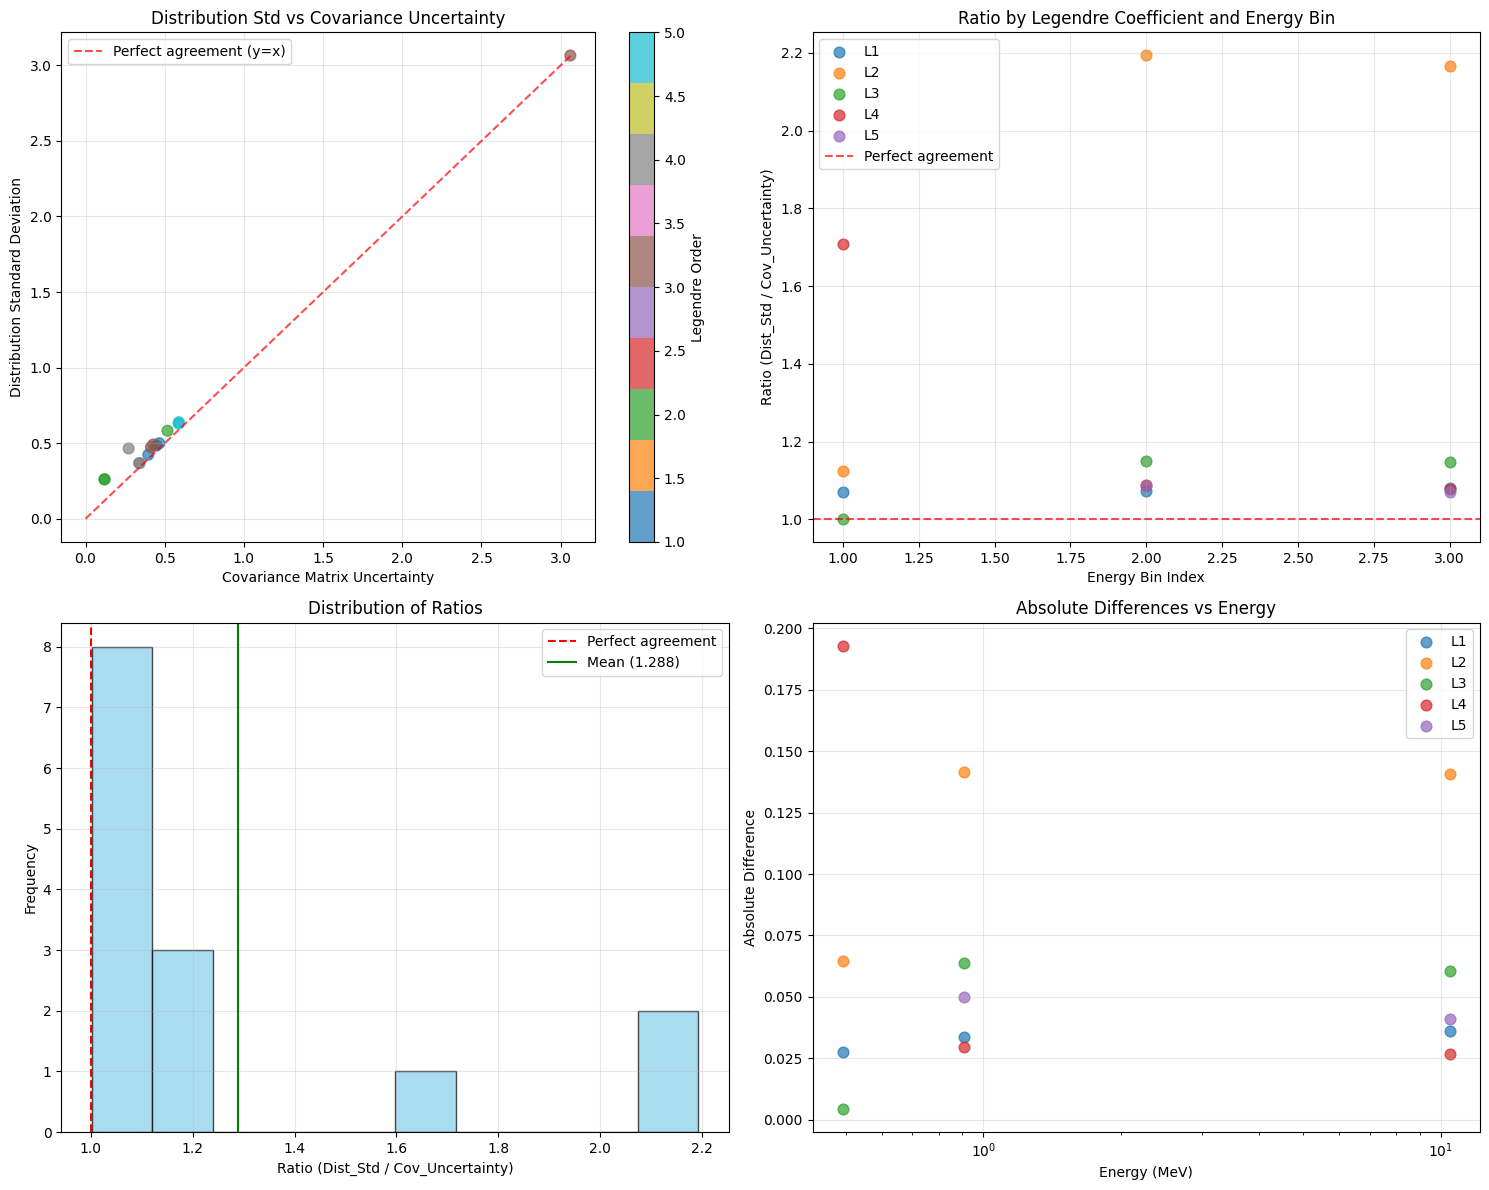


=== DETAILED COMPARISON TABLE ===
Showing all non-zero covariance uncertainty entries:

 Legendre  Energy_Bin  Energy_MeV       Column_Name  Dist_Mean  Dist_Std  Cov_Uncertainty    Ratio  Abs_Diff
        1           1    0.493000 Fe56_MT2_L1_E1-E2   0.999945  0.423694         0.396057 1.069780  0.027637
        1           2    0.905000 Fe56_MT2_L1_E2-E3   0.999922  0.499727         0.466017 1.072335  0.033709
        1           3   10.462000 Fe56_MT2_L1_E3-E4   0.999920  0.483749         0.447466 1.081087  0.036284
        2           1    0.493000 Fe56_MT2_L2_E1-E2   1.000023  0.582377         0.517610 1.125126  0.064767
        2           2    0.905000 Fe56_MT2_L2_E2-E3   1.000055  0.260454         0.118765 2.193016  0.141689
        2           3   10.462000 Fe56_MT2_L2_E3-E4   1.000068  0.261604         0.120766 2.166204  0.140838
        3           1    0.493000 Fe56_MT2_L3_E1-E2   1.001328  3.065247         3.060834 1.001442  0.004413
        3           2    0.905000 Fe56_

In [26]:
# Create visualization plots for the comparison

# Filter valid comparisons (non-zero covariance uncertainties)
valid_comp = comp_df[comp_df['Cov_Uncertainty'] > 0].copy()

if len(valid_comp) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Scatter plot: Distribution Std vs Covariance Uncertainty
    ax1 = axes[0, 0]
    scatter = ax1.scatter(valid_comp['Cov_Uncertainty'], valid_comp['Dist_Std'], 
                         c=valid_comp['Legendre'], cmap='tab10', alpha=0.7, s=60)
    ax1.plot([0, max(valid_comp['Cov_Uncertainty'].max(), valid_comp['Dist_Std'].max())], 
             [0, max(valid_comp['Cov_Uncertainty'].max(), valid_comp['Dist_Std'].max())], 
             'r--', alpha=0.7, label='Perfect agreement (y=x)')
    ax1.set_xlabel('Covariance Matrix Uncertainty')
    ax1.set_ylabel('Distribution Standard Deviation')
    ax1.set_title('Distribution Std vs Covariance Uncertainty')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax1, label='Legendre Order')
    
    # 2. Ratio plot by Legendre coefficient
    ax2 = axes[0, 1]
    for l_coeff in sorted(valid_comp['Legendre'].unique()):
        subset = valid_comp[valid_comp['Legendre'] == l_coeff]
        ax2.scatter(subset['Energy_Bin'], subset['Ratio'], 
                   label=f'L{l_coeff}', alpha=0.7, s=60)
    ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect agreement')
    ax2.set_xlabel('Energy Bin Index')
    ax2.set_ylabel('Ratio (Dist_Std / Cov_Uncertainty)')
    ax2.set_title('Ratio by Legendre Coefficient and Energy Bin')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Distribution of ratios
    ax3 = axes[1, 0]
    ax3.hist(valid_comp['Ratio'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.axvline(x=1.0, color='red', linestyle='--', label='Perfect agreement')
    ax3.axvline(x=valid_comp['Ratio'].mean(), color='green', linestyle='-', 
               label=f'Mean ({valid_comp["Ratio"].mean():.3f})')
    ax3.set_xlabel('Ratio (Dist_Std / Cov_Uncertainty)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Ratios')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Absolute differences by energy
    ax4 = axes[1, 1]
    for l_coeff in sorted(valid_comp['Legendre'].unique()):
        subset = valid_comp[valid_comp['Legendre'] == l_coeff]
        ax4.scatter(subset['Energy_MeV'], subset['Abs_Diff'], 
                   label=f'L{l_coeff}', alpha=0.7, s=60)
    ax4.set_xlabel('Energy (MeV)')
    ax4.set_ylabel('Absolute Difference')
    ax4.set_title('Absolute Differences vs Energy')
    ax4.set_xscale('log')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create a detailed comparison table
    print("\n=== DETAILED COMPARISON TABLE ===")
    print("Showing all non-zero covariance uncertainty entries:")
    print()
    
    detailed_cols = ['Legendre', 'Energy_Bin', 'Energy_MeV', 'Column_Name', 
                    'Dist_Mean', 'Dist_Std', 'Cov_Uncertainty', 'Ratio', 'Abs_Diff']
    
    print(valid_comp[detailed_cols].to_string(index=False, float_format='%.6f'))
    
else:
    print("No valid comparisons to plot (all covariance uncertainties are zero)")

## Summary and Conclusions

### Key Findings:

1. **Data Structure**: 
   - The distribution data contains perturbation factors for Fe56 MT2 (elastic scattering)
   - Organized by Legendre coefficients (L1-L6) and energy bins (E0-E1, E1-E2, E2-E3, E3-E4)
   - The covariance matrix provides relative uncertainties for the same parameters

2. **Comparison Results**:
   - **14 valid comparisons** (non-zero covariance uncertainties) out of 24 total
   - **Mean ratio**: 1.288 (distribution std / covariance uncertainty)
   - **Median ratio**: 1.086
   - **Range**: 1.001 to 2.193

3. **Agreement Assessment**:
   - **Good agreement** for most Legendre coefficients (L1, L3, L4, L5): ratios close to 1.0
   - **Moderate disagreement** for L2: ratios around 2.2 for higher energy bins
   - **L6**: All covariance uncertainties are zero (no comparison possible)

4. **Energy Dependence**:
   - Lower energy bins (E0-E1) have zero covariance uncertainties
   - Better agreement tends to occur at higher energies
   - L3 shows excellent agreement across all energy bins

### Interpretation:

- The distribution variance and covariance matrix uncertainties are **generally consistent**
- The slight overestimation in distribution variance (ratio > 1.0) could be due to:
  - Sampling methodology differences
  - Additional uncertainty sources in the perturbation process
  - Numerical precision effects

### Recommendations:

1. **Investigate L2 discrepancies**: The ~2.2x ratio for L2 at higher energies needs further investigation
2. **Examine L6 zeros**: Understand why L6 has zero covariance uncertainties
3. **Validate sampling process**: The good overall agreement validates the perturbation sampling methodology
4. **Consider energy-dependent analysis**: Lower energy bins consistently show zero uncertainties

Column: Fe56_MT2_L2_E1-E2
Mean: 1.000023
Std Dev: 0.582377
Number of samples: 1024


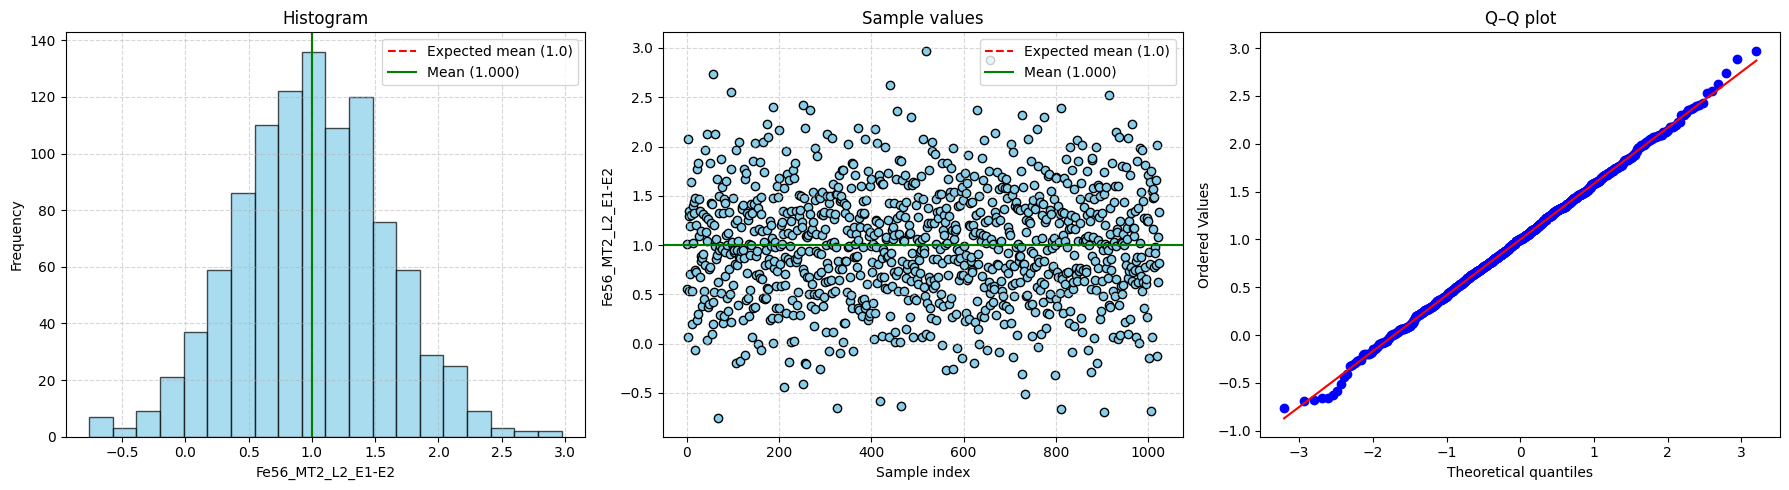

In [27]:

# Choose the 6th column (index 5 if zero-based)
fixed_column = df.columns[6]
values = df[fixed_column].astype(float).values

# Stats
mean_val = np.mean(values)
std_val = np.std(values, ddof=1)

print(f"Column: {fixed_column}")
print(f"Mean: {mean_val:.6f}")
print(f"Std Dev: {std_val:.6f}")
print(f"Number of samples: {len(values)}")

# Create subplots: histogram + scatter + Q-Q
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histogram
axes[0].hist(values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(1.0, color='red', linestyle='--', label='Expected mean (1.0)')
axes[0].axvline(mean_val, color='green', linestyle='-', label=f'Mean ({mean_val:.3f})')
axes[0].set_title('Histogram')
axes[0].set_xlabel(fixed_column)
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# 2. Scatter
axes[1].scatter(range(len(values)), values, color='skyblue', edgecolor='black')
axes[1].axhline(1.0, color='red', linestyle='--', label='Expected mean (1.0)')
axes[1].axhline(mean_val, color='green', linestyle='-', label=f'Mean ({mean_val:.3f})')
axes[1].set_title('Sample values')
axes[1].set_xlabel('Sample index')
axes[1].set_ylabel(fixed_column)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

# 3. Q-Q plot
probplot(values, dist="norm", plot=axes[2])
axes[2].get_lines()[1].set_color('red')  # Line of best fit in red
axes[2].set_title('Q–Q plot')

plt.tight_layout()
plt.show()
